ResNet Model 152

In [2]:
import tensorflow as tf

print("GPU Available:", tf.test.is_gpu_available())
print("GPU Device Name:", tf.config.list_physical_devices('GPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


GPU Available: True
GPU Device Name: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


Step 1: Setup & Load Dataset

In [4]:
import os
import zipfile

# Define dataset path
dataset_path = "/content/isic2020.zip"
extract_path = "/content/skin_dataset"

# Create directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Extract the dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check extracted files
print("Extracted files:", os.listdir(extract_path))


Extracted files: ['isic2020']


In [5]:
import shutil
import os

actual_path = "/content/skin_dataset/isic2020"

# Create directory if it doesn't exist
if not os.path.exists(extract_path):
    os.makedirs(extract_path)

# Move contents up
for item in os.listdir(actual_path):
    shutil.move(os.path.join(actual_path, item), extract_path)

# Remove empty nested folder if it exists
if os.path.exists(actual_path):
    os.rmdir(actual_path)

print("Fixed dataset structure:", os.listdir(extract_path))


Fixed dataset structure: ['.ipynb_checkpoints', 'test', 'train', 'train.csv', 'test.csv']


In [6]:
import pandas as pd
import os

# Path to the CSV file
csv_path = "/content/skin_dataset/train.csv"

# Check if the file exists before loading
if os.path.exists(csv_path):
    # Load CSV file
    df = pd.read_csv(csv_path)

    # Print column names
    print("Columns in the CSV file:")
    print(df.columns)
else:
    print("CSV file not found at the specified path.")


Columns in the CSV file:
Index(['image_name', 'patient_id', 'sex', 'age_approx',
       'anatom_site_general_challenge', 'diagnosis', 'benign_malignant',
       'target'],
      dtype='object')


Step 2: Organizing the Dataset


In [7]:
import os
import pandas as pd
import shutil

# Define paths
base_path = "/content/skin_dataset"
train_csv_path = os.path.join(base_path, "train.csv")
train_images_path = os.path.join(base_path, "train")

# Load CSV
df = pd.read_csv(train_csv_path)

# Create directories for classification
malignant_path = os.path.join(train_images_path, "malignant")
benign_path = os.path.join(train_images_path, "benign")

os.makedirs(malignant_path, exist_ok=True)
os.makedirs(benign_path, exist_ok=True)

# Move images to respective directories
for _, row in df.iterrows():
    image_name = row["image_name"] + ".jpg"  # Add .jpg extension
    label = row["target"]  # 1 for malignant, 0 for benign

    src = os.path.join(train_images_path, image_name)
    dest = os.path.join(malignant_path if label == 1 else benign_path, image_name)

    if os.path.exists(src):  # Ensure file exists before moving
        shutil.move(src, dest)

print("Images sorted into 'malignant' and 'benign' folders.")


Images sorted into 'malignant' and 'benign' folders.


In [8]:
import os
import pandas as pd
import shutil

# Define paths
base_path = "/content/skin_dataset"
test_csv_path = os.path.join(base_path, "test.csv")
test_images_path = os.path.join(base_path, "test")

# Load CSV
df = pd.read_csv(test_csv_path)

# Create directories for classification (if not already created)
malignant_path = os.path.join(test_images_path, "malignant")
benign_path = os.path.join(test_images_path, "benign")

os.makedirs(malignant_path, exist_ok=True)
os.makedirs(benign_path, exist_ok=True)

# Move images to respective directories
for _, row in df.iterrows():
    image_name = row["image_name"] + ".jpg"  # Add .jpg extension
    label = row["target"]  # 1 for malignant, 0 for benign

    src = os.path.join(test_images_path, image_name)
    dest = os.path.join(malignant_path if label == 1 else benign_path, image_name)

    if os.path.exists(src):  # Ensure file exists before moving
        shutil.move(src, dest)

print("Test images sorted into 'malignant' and 'benign' folders.")


Test images sorted into 'malignant' and 'benign' folders.


Step 3: Preprocess Data & Custom Dataset Class

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

# Define transformations for data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to ResNet input size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
])

class SkinDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.images = []
        self.labels = []

        # Load image paths and labels
        for label, category in enumerate(["benign", "malignant"]):
            category_path = os.path.join(root_dir, category)
            for img_name in os.listdir(category_path):
                img_path = os.path.join(category_path, img_name)
                self.images.append(img_path)
                self.labels.append(label)  # 0 for benign, 1 for malignant

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        label = self.labels[idx]

        # Load image
        image = Image.open(img_path).convert("RGB")  # Ensure 3 channels

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Initialize dataset
train_dataset = SkinDataset(root_dir="/content/skin_dataset/train", transform=transform)

# Verify dataset
print(f"Total images in dataset: {len(train_dataset)}")
sample_img, sample_label = train_dataset[0]
print(f"Sample image shape: {sample_img.shape}, Label: {sample_label}")


Total images in dataset: 30519
Sample image shape: torch.Size([3, 224, 224]), Label: 0


Step 4: Splitting Dataset into Train, Validation, and Test Sets

In [10]:
from torch.utils.data import random_split

# Define dataset split sizes (80% train, 10% val, 10% test)
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size  # Remaining for test

# Split dataset
train_set, val_set, test_set = random_split(train_dataset, [train_size, val_size, test_size])

# Create DataLoaders for batch processing
batch_size = 32

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Verify sizes
print(f"Train Set: {len(train_set)}, Validation Set: {len(val_set)}, Test Set: {len(test_set)}")


Train Set: 24415, Validation Set: 3051, Test Set: 3053


Step 5: Define the Residual Bottleneck Block

In [11]:
import torch
import torch.nn as nn

class BottleneckBlock(nn.Module):
    expansion = 4  # Increases channels at last 1x1 conv

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BottleneckBlock, self).__init__()

        # 1x1 conv (Reduce dimensions)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        # 3x3 conv (Main feature extraction)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # 1x1 conv (Expand dimensions)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        # Activation function
        self.relu = nn.ReLU(inplace=True)

        # Skip connection (Identity Mapping)
        self.downsample = downsample

    def forward(self, x):
        identity = x  # Save input for skip connection

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        # Apply skip connection
        if self.downsample:
            identity = self.downsample(x)  # Adjust shape if needed

        out += identity  # Add skip connection
        out = self.relu(out)  # Final activation

        return out

Step 6: Build Custom ResNet-152 Architecture

In [12]:
class ResNet152(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet152, self).__init__()

        # Initial Conv Layer
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual layers
        self.layer1 = self._make_layer(64, 64, 3)   # Conv2_x
        self.layer2 = self._make_layer(256, 128, 8, stride=2)  # Conv3_x
        self.layer3 = self._make_layer(512, 256, 36, stride=2)  # Conv4_x
        self.layer4 = self._make_layer(1024, 512, 3, stride=2)  # Conv5_x

        # Global Average Pool & Fully Connected Layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(2048, num_classes)  # Output classes

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        """Create a stack of bottleneck blocks"""
        downsample = None

        # If dimensions change, apply 1x1 conv in shortcut connection
        if stride != 1 or in_channels != out_channels * BottleneckBlock.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * BottleneckBlock.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * BottleneckBlock.expansion)
            )

        layers = []
        layers.append(BottleneckBlock(in_channels, out_channels, stride, downsample))  # First block
        in_channels = out_channels * BottleneckBlock.expansion  # Update channels

        for _ in range(1, blocks):  # Remaining blocks
            layers.append(BottleneckBlock(in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x


Step 7: Train the Custom ResNet-152

Step 7.1: Load Pretrained Weights


In [13]:
import torchvision.models as models

# Load pretrained ResNet-152
pretrained_resnet = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)

# Modify the final fully connected layer for our dataset
num_ftrs = pretrained_resnet.fc.in_features
pretrained_resnet.fc = nn.Linear(num_ftrs, 2)  # Assuming 2 classes (Benign/Malignant)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
pretrained_resnet = pretrained_resnet.to(device)


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 167MB/s]


Step 7.2: Define Loss Function & Optimizer


In [14]:
import torch.optim as optim

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer
optimizer = optim.Adam(pretrained_resnet.parameters(), lr=0.0001)


Step 7.3: Prepare Data Loaders


In [15]:
from torchvision import transforms, datasets

# Define data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize to [-1,1]
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])
}

# Load datasets
data_dir = "/content/skin_dataset"

train_dataset = datasets.ImageFolder(root=f"{data_dir}/train", transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(root=f"{data_dir}/test", transform=data_transforms['test'])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


Step 8: Train the Model

In [16]:
import matplotlib.pyplot as plt

def train_model_with_metrics(model, train_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = correct / total

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

    return model, train_losses, train_accuracies


In [17]:
def plot_training_curves(train_losses, train_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, marker='o', linestyle='-', color='r', label="Training Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Curve")
    plt.legend()

    # Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, marker='o', linestyle='-', color='b', label="Training Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Curve")
    plt.legend()

    plt.show()


Epoch 1/10, Loss: 0.0820, Accuracy: 0.9821
Epoch 2/10, Loss: 0.0750, Accuracy: 0.9823
Epoch 3/10, Loss: 0.0730, Accuracy: 0.9823
Epoch 4/10, Loss: 0.0712, Accuracy: 0.9823
Epoch 5/10, Loss: 0.0689, Accuracy: 0.9823
Epoch 6/10, Loss: 0.0673, Accuracy: 0.9823
Epoch 7/10, Loss: 0.0641, Accuracy: 0.9823
Epoch 8/10, Loss: 0.0601, Accuracy: 0.9823
Epoch 9/10, Loss: 0.0531, Accuracy: 0.9834
Epoch 10/10, Loss: 0.0440, Accuracy: 0.9857


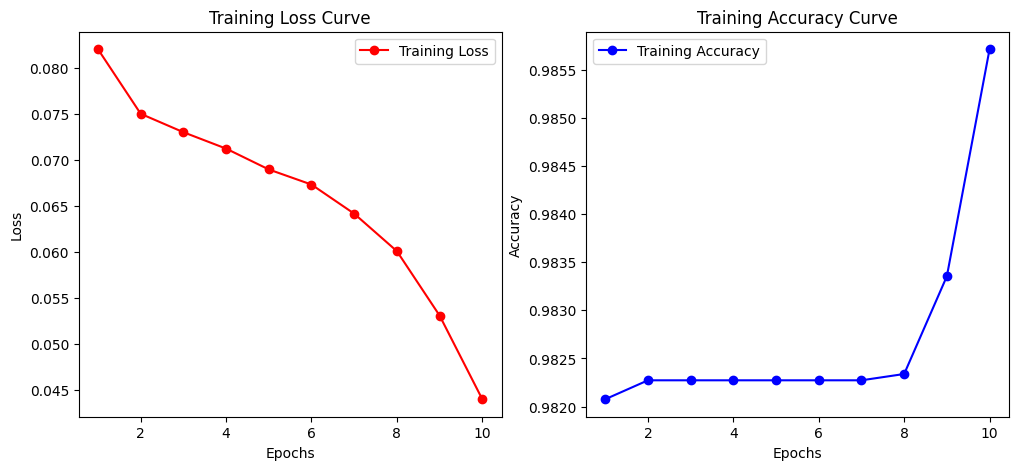

In [18]:
# Train the model with metrics tracking
trained_model, train_losses, train_accuracies = train_model_with_metrics(pretrained_resnet, train_loader, criterion, optimizer, num_epochs=10)

# Plot training curves
plot_training_curves(train_losses, train_accuracies)


Step 9: Evaluate the Model on the Test Set


In [19]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Compute evaluation metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")

    return accuracy, precision, recall, f1


In [20]:
evaluate_model(pretrained_resnet, test_loader)

Test Accuracy: 0.9812
Precision: 0.4286
Recall: 0.0750
F1-score: 0.1277


(0.9812098991750687, 0.42857142857142855, 0.075, 0.1276595744680851)